<a href="https://colab.research.google.com/github/Mohit501/CGAN-on-MNIST/blob/main/CGAN_on_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing required libraries

In [1]:
from tensorflow import keras
from keras.layers import Activation,Dense,Input,Conv2D,Flatten,Reshape,Conv2DTranspose,LeakyReLU,BatchNormalization,concatenate
from keras.optimizers import RMSprop
from keras.models import Model,load_model
from keras.datasets import mnist
from keras.utils import to_categorical,plot_model
import numpy as np
import os
import math
import matplotlib.pyplot as plt
import argparse

## Building Generator

In [2]:
def build_generator(inputs,labels,image_size):
  image_resize = image_size//4
  kernel_size = 5
  layer_filter =  [128,64,32,1]
  x = concatenate([inputs,labels],axis = 1)
  x = Dense(image_resize*image_resize*layer_filter[0])(x)
  x = Reshape((image_resize,image_resize,layer_filter[0]))(x)
  for filter in layer_filter:
      if filter > layer_filter[-2]:
        strides = 2
      else:
        strides = 1
      x = BatchNormalization()(x)
      x = Activation('relu')(x)
      x = Conv2DTranspose(filters=  filter,kernel_size=kernel_size,strides=strides,padding = 'same')(x)

  x = Activation('sigmoid')(x)
  generator  = Model([inputs,labels],x,name = 'generator')
  return generator

# Building Discriminator

In [3]:
def build_discriminator(inputs, labels, image_size):  
    kernel_size = 5
    layer_filters = [32, 64, 128, 256]
    x = inputs
    y = Dense(image_size * image_size)(labels)
    y = Reshape((image_size, image_size, 1))(y)
    x = concatenate([x, y])
    for filters in layer_filters:
        if filters == layer_filters[-1]:
            strides = 1
        else:
            strides = 2
        x = LeakyReLU(alpha=0.2)(x)
        x = Conv2D(filters=filters,kernel_size=kernel_size,strides=strides,padding='same')(x)
    x = Flatten()(x)
    x = Dense(1)(x)
    x = Activation('sigmoid')(x)
    discriminator = Model([inputs, labels], x, name='discriminator')
    return discriminator

# Building a trian function

In [4]:
 def train(models,data,params):
    generator, discriminator, adversarial = models
    x_train, y_train = data
    batch_size, latent_size, train_steps, num_labels, model_name = params
    save_interval = 1000
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, latent_size])
    noise_class = np.eye(num_labels)[np.arange(0, 16) % num_labels]
    train_size = x_train.shape[0]
    print(model_name,"Labels for generated images: ", np.argmax(noise_class, axis=1))
    for i in range(train_steps):
        rand_indexes = np.random.randint(0, train_size, size=batch_size)
        real_images = x_train[rand_indexes]
        real_labels = y_train[rand_indexes]
       
        noise = np.random.uniform(-1.0,1.0,size=[batch_size, latent_size])
        
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels,batch_size)]
        fake_images = generator.predict([noise, fake_labels])
        x = np.concatenate((real_images, fake_images))
        labels = np.concatenate((real_labels, fake_labels))
        y = np.ones([2 * batch_size, 1])
        y[batch_size:, :] = 0.0
        loss, acc = discriminator.train_on_batch([x, labels], y)
        log = "%d: [discriminator loss: %f, acc: %f]" % (i, loss, acc)
        noise = np.random.uniform(-1.0,1.0,size=[batch_size, latent_size])
        fake_labels = np.eye(num_labels)[np.random.choice(num_labels,batch_size)]
        y = np.ones([batch_size, 1])
        loss, acc = adversarial.train_on_batch([noise, fake_labels], y)
        log = "%s [adversarial loss: %f, acc: %f]" % (log, loss, acc)
        print(log)
        if (i + 1) % save_interval == 0:
            plot_images(generator,noise_input=noise_input,noise_class=noise_class,show=False,step=(i + 1),model_name=model_name)
    
  
    generator.save(model_name + ".h5")

## Creating a Plot Function

In [5]:
def plot_images(generator,noise_input,noise_class,show=False,step=0,model_name="gan"):
    os.makedirs(model_name, exist_ok=True)
    filename = os.path.join(model_name, "%05d.png" % step)
    images = generator.predict([noise_input, noise_class])
    print(model_name , " labels for generated images: ", np.argmax(noise_class, axis=1))
    plt.figure(figsize=(3,3))
    num_images = images.shape[0]
    image_size = images.shape[1]
    rows = int(math.sqrt(noise_input.shape[0]))
    for i in range(num_images):
        plt.subplot(rows, rows, i + 1)
        image = np.reshape(images[i], [image_size, image_size])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
    plt.savefig(filename)
    if show:
        plt.show()
    else:
        plt.close('all')


# Build and Train Function

In [6]:

def build_and_train_models():
    (x_train, y_train), (_, _) = mnist.load_data()
    image_size = x_train.shape[1]
    x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
    x_train = x_train.astype('float32') / 255

    num_labels = np.amax(y_train) + 1
    y_train = to_categorical(y_train)

    model_name = "cgan_mnist"
    latent_size = 100
    batch_size = 64
    train_steps = 40000
    lr = 2e-4
    decay = 6e-8
    input_shape = (image_size, image_size, 1)
    label_shape = (num_labels, )

    
    inputs = Input(shape=input_shape, name='discriminator_input')
    labels = Input(shape=label_shape, name='class_labels')

    discriminator = build_discriminator(inputs, labels, image_size)
    optimizer = RMSprop(lr=lr, decay=decay)
    discriminator.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])
    discriminator.summary()
    input_shape = (latent_size, )
    inputs = Input(shape=input_shape, name='z_input')
    generator = build_generator(inputs, labels, image_size)
    generator.summary()
    optimizer = RMSprop(lr=lr*0.5, decay=decay*0.5)
    
    discriminator.trainable = False
    outputs = discriminator([generator([inputs, labels]), labels])
    adversarial = Model([inputs, labels],
                        outputs,
                        name=model_name)
    adversarial.compile(loss='binary_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
    adversarial.summary()
    models = (generator, discriminator, adversarial)
    data = (x_train, y_train)
    params = (batch_size, latent_size, train_steps, num_labels, model_name)
    train(models, data, params)

In [7]:
def test_generator(generator, class_label=None):
    noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
    step = 0
    if class_label is None:
        num_labels = 10
        noise_class = np.eye(num_labels)[np.random.choice(num_labels, 16)]
    else:
        noise_class = np.zeros((16, 10))
        noise_class[:,class_label] = 1
        step = class_label

    plot_images(generator,
                noise_input=noise_input,
                noise_class=noise_class,
                show=True,
                step=step,
                model_name="test_outputs")

In [8]:
build_and_train_models()

Streaming output truncated to the last 5000 lines.
35005: [discriminator loss: 0.617507, acc: 0.632812] [adversarial loss: 1.129732, acc: 0.187500]
35006: [discriminator loss: 0.568334, acc: 0.718750] [adversarial loss: 0.861671, acc: 0.421875]
35007: [discriminator loss: 0.544283, acc: 0.710938] [adversarial loss: 1.230737, acc: 0.171875]
35008: [discriminator loss: 0.560755, acc: 0.703125] [adversarial loss: 0.980587, acc: 0.312500]
35009: [discriminator loss: 0.588732, acc: 0.671875] [adversarial loss: 1.139206, acc: 0.187500]
35010: [discriminator loss: 0.632845, acc: 0.601562] [adversarial loss: 0.909235, acc: 0.406250]
35011: [discriminator loss: 0.604311, acc: 0.664062] [adversarial loss: 1.333366, acc: 0.093750]
35012: [discriminator loss: 0.606215, acc: 0.656250] [adversarial loss: 1.003124, acc: 0.343750]
35013: [discriminator loss: 0.624749, acc: 0.687500] [adversarial loss: 1.113688, acc: 0.234375]
35014: [discriminator loss: 0.607759, acc: 0.648438] [adversarial loss: 0.79

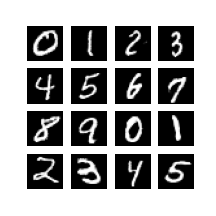

In [10]:
from PIL import Image
Image.open('/content/cgan_mnist/01000.png')


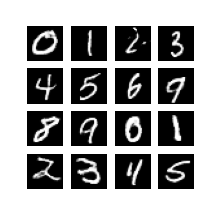

In [11]:
Image.open('/content/cgan_mnist/21000.png')